In [1]:
# import required libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# import dataset as dataframe
df = pd.read_csv('Dataset_1.csv')

# data cleaning, downsampling date to months
df['Date_of_Survey'] = pd.to_datetime(df['Date_of_Survey']).dt.to_period("M")

There are a total of 2386 survey responses collected 11 unique time points.
100.0% of survey 1 and 100.0% of survey 2 have responses.
Approximately 24.56% of Q1 and 32.02% of Q2 is a 4.


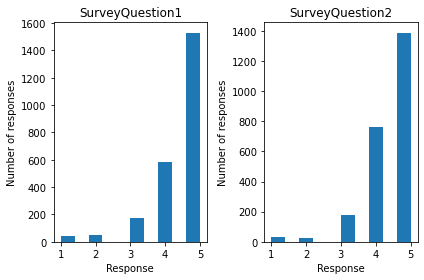

In [11]:
# some basic exploratory data analysis
print('There are a total of ' + str(df.shape[0]) + ' survey responses collected across ' + str(len(df['Date_of_Survey'].unique())) + ' unique time points.' )

pct_1 = (1 - df['SurveyQuestion1'].isnull().mean()) * 100
pct_2 = (1 - df['SurveyQuestion2'].isnull().mean()) * 100

print(str(pct_1) + '% of survey 1 and ' + str(pct_2) + '% of survey 2 have responses.')
print('Approximately ' + str(np.round(np.mean(df['SurveyQuestion1']==4)*100,2)) + '% of Q1 and ' + str(np.round(np.mean(df['SurveyQuestion2']==4)*100,2)) + '% of Q2 is a 4.')


plt.subplot(1,2,1)
plt.hist(df['SurveyQuestion1'])
plt.xlabel('Response'), plt.ylabel('Number of responses'), plt.title('SurveyQuestion1')

plt.subplot(1,2,2)
plt.hist(df['SurveyQuestion2'])
plt.xlabel('Response'), plt.ylabel('Number of responses'), plt.title('SurveyQuestion2')
plt.tight_layout()
plt.show()

In [ ]:
# build aggregate functions for survey questions
def pct_excellent(series):
    return np.mean(series==5) * 100

def pct_gfp(series):
    return np.mean((df['SurveyQuestion1'] == 3) | (df['SurveyQuestion1'] == 2) | (df['SurveyQuestion1'] == 1)) * 100


In [ ]:
# build dataframes for each survey question
pct_df_1 = df.groupby('Date_of_Survey').aggregate({'SurveyQuestion1': [pct_excellent, pct_gfp]})
pct_df_1.columns = pct_df_1.columns.droplevel()
pct_df_1['net_score'] = np.round((pct_df_1['pct_excellent'] - pct_df_1['pct_gfp'])*100,1)
pct_df_1['SurveyQuestion'] = '1'
pct_df_1 = pct_df_1.reset_index()

pct_df_2 = df.groupby('Date_of_Survey').aggregate({'SurveyQuestion2': [pct_excellent, pct_gfp]})
pct_df_2.columns = pct_df_2.columns.droplevel()
pct_df_2['net_score'] = np.round((pct_df_2['pct_excellent'] - pct_df_2['pct_gfp'])*100,1)
pct_df_2['SurveyQuestion'] = '2'
pct_df_2 = pct_df_2.reset_index()

In [ ]:
# concatenate dataframes, reorder, and output 
final_df = pd.concat([pct_df_1,pct_df_2])
column_list = final_df.columns.tolist()
new_column_list = column_list[-1:] + column_list[:-1]

final_df = final_df[new_column_list].sort_values(['SurveyQuestion','Date_of_Survey'])
final_df = final_df.reset_index(drop=True)
final_df.rename(columns = {'pct_excellent' : '%Excellent',
                          'pct_gfp' : '%Good/Fair/Poor',
                          'net_score': 'Net Score'}, inplace=True)
final_df.to_csv('./products/assignment_1_results.csv')

In [ ]:
# plot showing trends of Q1 to Q2
plot_df = final_df.copy()
plot_df['Date_of_Survey'] = plot_df['Date_of_Survey'].dt.to_timestamp()

# select data and calculate r
s1_data = plot_df[plot_df['SurveyQuestion'] == '1']
s2_data = plot_df[plot_df['SurveyQuestion'] == '2']
# note high correlation between s1 and s2 net score suggesting that Q2 doesn't really add too much. 
corr_value = np.round(np.corrcoef(s1_data['Net Score'], s2_data['Net Score'])[0,1],2)

# plot figure 
plt.figure(figsize = (8,8))
plt.rcParams.update({'font.size': 16})
plt.plot_date(s1_data['Date_of_Survey'], s1_data['Net Score'], 'bo-')
plt.plot_date(s2_data['Date_of_Survey'], s2_data['Net Score'], 'ro-')

plt.xticks(rotation = 45, ha="right")
plt.xlabel('Date of Survey'), plt.ylabel('Net Score')
plt.legend(['Q1','Q2'])
plt.title('Correlation between Q1 and Q2 response : ' + str(corr_value))
plt.tight_layout()

plt.savefig('./products/assignment_1_result.png')
plt.show()
